Try to replicate this with NDVI time-series, using features such as soil moisture and rainfall
https://nixtla.github.io/mlforecast/forecast.html



## Description



### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datacube import Datacube
import xarray as xr
import numpy as np
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from load_era5 import load_era5

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:34395 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


### Analysis parameters

Define location and time period of interest.
The time period is chosen to be less than a year to limit ERA5 data download.

In [3]:
# Define the analysis region (Lat-Lon box)
lat, lon =  -30.4716, 146.1192
buffer = 0.05

lon=(lon - buffer, lon + buffer)
lat=(lat - buffer, lat + buffer)

# Define the time window
time = '2019-01-01', '2020-12-30'

In [4]:
display_map(lon,lat)

## Extract satellite data

In [5]:
dc = Datacube(app='whatevrr')

query = {'lon': lon,
         'lat': lat,
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

ds = load_ard(dc=dc, 
              dask_chunks={'x':-1, 'y':-1, 'time':-1},
              products=["ga_ls7e_ard_3", "ga_ls8c_ard_3"],#['s2a_ard_granule','s2b_ard_granule'],
              **query)


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Finding datasets
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 86 time steps as a dask array


### Calculate NDVI time-series

In [6]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='ga_ls_3')

#interpolate NDVI to a monthly frequency
ndvi = ndvi.interpolate_na(dim='time', method='linear',).resample(time="1W").interpolate("linear")
ndvi=ndvi.mean(['x','y'])
ndvi = ndvi.NDVI.compute()

Dropping bands ['nbart_red', 'nbart_nir']


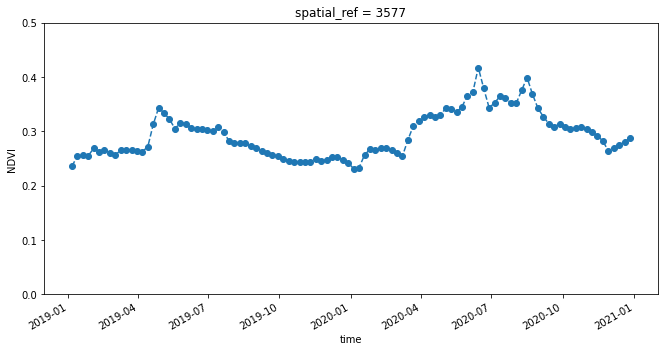

In [7]:
ndvi.plot(figsize=(11,5),linestyle='dashed', marker='o')
plt.ylim(0,0.5);

## Retrieval of surface and root-zone wetness

> `Surface wetness` is measured relative to wettest condition recorded for a location.

> `Rootzone Soil Water Index` is derived from surface relative wetness

In [8]:
# function to load soil moisture data

def load_soil_moisture(lat, lon, time, grid=None, product = 'surface'):
    product_baseurl = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/'
    assert product in ['surface', 'rootzone'], 'product parameter must be surface or root-zone'
    # define a grid that covers the entire area of interest
    lat_range = np.arange(np.max(np.ceil(np.array(lat)*10.+0.5)/10.-0.05), np.min(np.floor(np.array(lat)*10.-0.5)/10.+0.05)-0.05, -0.1)
    lon_range = np.arange(np.min(np.floor(np.array(lon)*10.-0.5)/10.+0.05), np.max(np.ceil(np.array(lon)*10.+0.5)/10.-0.05)+0.05, 0.1)
    # split time window into years
    day_range = np.array(time).astype("M8[D]")
    year_range = np.array(time).astype("M8[Y]")
    if product == 'surface':
        product_name = 'GRAFS_TopSoilRelativeWetness_'
    else: product_name = 'GRAFS_RootzoneSoilWaterIndex_'
    datasets = []
    for year in np.arange(year_range[0], year_range[1]+1, np.timedelta64(1, 'Y')):
        start = np.max([day_range[0], year.astype("M8[D]")])
        end = np.min([day_range[1], (year+1).astype("M8[D]")-1])
        product_url = product_baseurl + product_name +'%s.nc'%str(year)
        print(product_url)
        # data is loaded lazily through OPeNDAP
        ds = xr.open_dataset(product_url)
        # slice before return
        ds = ds.sel(lat=lat_range, lon=lon_range, time=slice(start, end)).compute()
        datasets.append(ds)
    return xr.merge(datasets)

# Retrieve surface soil moisture using query parameters
surface_wetness = load_soil_moisture(lat, lon, time) #grid='nearest'

# retrieve rootzone soil moisture using query parameters
rootzone_wetness = load_soil_moisture(lat, lon, time, product='rootzone') #grid='nearest'

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2019.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2020.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2019.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2020.nc


## Retrieve precipitation data from ERA5


In [9]:
# load precipitation data from ERA5
var_precipitation = 'precipitation_amount_1hour_Accumulation'
precipitation = load_era5(var_precipitation, lat, lon, time, reduce_func=np.sum, resample='1D')

# Convert from Meters (m) to Millimeters (mm)
precipitation[var_precipitation]=precipitation[var_precipitation]*1000

### Convert all datasets to 1D time-series

And resample to common time-step

In [11]:
precipitation=precipitation[var_precipitation].mean(['lat','lon']).drop('spatial_ref').compute()
surface_wetness=surface_wetness.relative_wetness.mean(['lat','lon'])
rootzone_wetness=rootzone_wetness.soil_water_index.mean(['lat','lon'])

In [12]:
precipitation=precipitation.resample(time="1W").interpolate("linear")
surface_wetness=surface_wetness.resample(time="1W").interpolate("linear")
rootzone_wetness=rootzone_wetness.resample(time="1W").interpolate("linear")

### Plot all datasets together

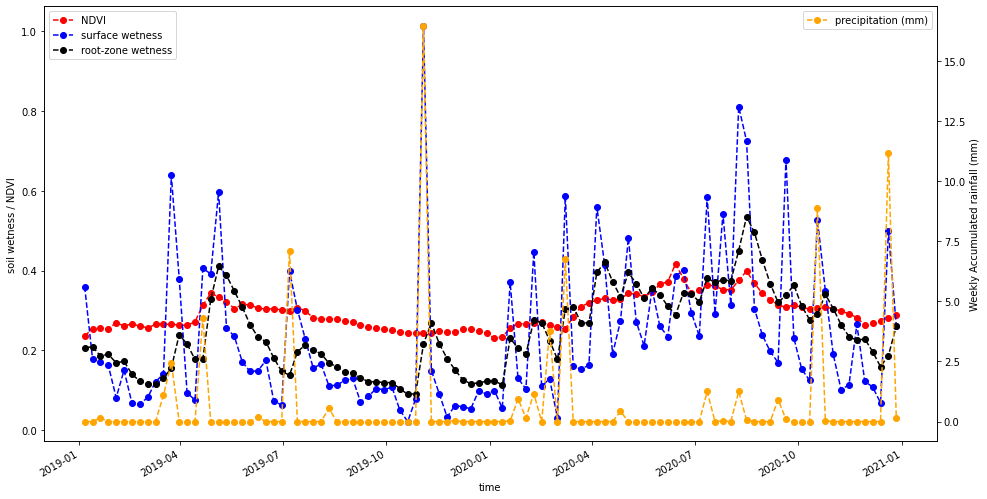

In [13]:
# plot soil moisture with precipitation
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
ndvi.plot(ax=ax1,label='NDVI',color='red',linestyle='dashed', marker='o')
surface_wetness.plot(ax = ax1,label='surface wetness',color='blue',linestyle='dashed', marker='o')
rootzone_wetness.plot(ax = ax1,label='root-zone wetness',color='black',linestyle='dashed', marker='o')
precipitation.plot(ax=ax2,label='precipitation (mm)',color='orange',linestyle='dashed', marker='o')
ax1.set_ylabel('soil wetness / NDVI')
ax2.set_ylabel('Weekly Accumulated rainfall (mm)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right');

## Convert to pandas dataframes

And put into a format that will fit with ml-forecast

In [14]:
surface_wetness=surface_wetness.to_dataframe()
rootzone_wetness=rootzone_wetness.to_dataframe()
precipitation=precipitation.to_dataframe()
ndvi=ndvi.drop('spatial_ref').to_dataframe().rename({'NDVI':'y'}, axis=1)

ndvi['surface_wetness']=surface_wetness['relative_wetness']
ndvi['rootzone_wetness']=rootzone_wetness['soil_water_index']
ndvi['rainfall']=precipitation['precipitation_amount_1hour_Accumulation']
ndvi = ndvi.dropna()
ndvi.head()

,y,surface_wetness,rootzone_wetness,rainfall
time,,,,
2019-01-06,0.235652,0.359924,0.206736,0.000000
2019-01-13,0.254645,0.178689,0.208966,0.000000
2019-01-20,0.256472,0.170282,0.186006,0.152588
2019-01-27,0.254534,0.162556,0.189751,0.000000
2019-02-03,0.268812,0.081408,0.168917,0.000000
